In [1]:
import numpy as np
from numba import njit
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
from matplotlib.colors import LogNorm, Normalize
import pandas as pd
import pickle
from datetime import datetime,timedelta, date
import strax
import straxen
import cutax
from tqdm.notebook import tqdm, trange
strax.utils.tqdm = tqdm
from multihist import Hist1d, Histdd

import copy
from matplotlib import cm
from scipy import stats
import feldman_cousins as fc
from scipy.stats import poisson
from scipy.optimize import minimize, rosen, rosen_der
import h5py

import GOFevaluation as ge
import scipy.stats as sps
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import tqdm

In [2]:
import os
style = os.path.join(os.environ['HOME'], 'nton/mplconfigs/stylelib/xenonnt.mplstyle')   
plt.style.use(style)

In [3]:
%matplotlib inline

In [4]:
mpl.rcParams['figure.dpi'] = 130
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 9

In [5]:
%run -i 'YBe_tool.py'
%run -i 'stuff_to_load.py'
mode='3-fold'
# mode='2-fold-only'

In [6]:
Y88_hl=106.6
kbq_initial=698
kbq_sim=389
day_lapse=-np.log(kbq_sim/kbq_initial)/np.log(2)*Y88_hl
#2022-6-1 initial date
source_date=datetime(2022,6,1)+timedelta(days=day_lapse)
dt=(datetime(2022,10,5)-source_date)/timedelta(days=1)

In [30]:
hour=183.78

# gamma_ineff=0.9 #NR inefficincy due to gamma coincident
# start_to_mid=0.9809

gamma_ratio=0.93356 #gamma ratio between YBe and Y88 run
# one_week_decay=np.exp(-7/(Y88_hl/np.log(2))) #fitted source decay rate

# sim_ratio=1/(start_to_mid*one_week_decay**2) #old scaling
sim_ratio=1/(np.exp(-dt/(Y88_hl/np.log(2)))) #new scaling

s_hour=15393*sim_ratio #hours of simulation, in the same rate as YBe run
b_hour=142.21*gamma_ratio #hours of background run, in the rate, in the same rate as YBe run
y_hour=365*24
bkg_s=hour/b_hour #pre-scaling for Y88 
sim_s=hour/s_hour #pre-scaling for YBe simulation

In [8]:
# data_cuts=pd.read_hdf("good_data.hdf5")
bkg=pd.read_hdf("/project2/lgrandi/dali/sghosh/Y88_event_info_143runs_142.21hrs_all_cuts_with_run_ids_v2.hdf5")
data=pd.read_hdf("/project2/lgrandi/dali/sghosh/YBe_event_info_239runs_183.78hrs_all_cuts_with_run_ids_v2.hdf5")

sim_raw=pd.read_csv("/project2/lgrandi/ghusheng/YBe_sim/ybeneu_low_event_info.csv")
sim_highE=pd.read_csv("/project2/lgrandi/scli/data/ybeneu_high_event_info.csv")



In [9]:
# df_0 = pd.read_csv('/project2/lgrandi/scli/data/ybe_neutron_nr_event_info.csv')

In [10]:
def get_entry(df):
    return int((max(df.time)-min(df.time))/1e9)


In [11]:
# mode='3-fold'

In [12]:
#quality cuts 3fold
if mode=='3-fold':
    ac_h5 = '/project2/lgrandi/ghusheng/YBe_sim/ac_ybe_0109.h5'

    with h5py.File(ac_h5, 'r', libver='latest', swmr=True) as ipt:
        normalization = ipt['fold3_df'].attrs['normalization']

    ac_sim = pd.read_hdf(ac_h5, key='fold3_df', columns=['cs1', 'cs2', 'cut_fiducial_volume', 'cut_near_wires','x','y','r','z'])
    data_cuts = data.query(' and '.join(targets_3fold[1:]))
    bkg_cuts = bkg.query(' and '.join(targets_3fold[1:]))
    sim = sim_raw.query(' and '.join(targets_3fold[1:]))
    ac_sim_cuts = ac_sim[ac_sim.cut_fiducial_volume]
    s1_bins=np.linspace(2.5,20.5,19)
    sim_high = sim_highE.query(' and '.join(targets_3fold[1:]))
    # del bkg
    # del data
    # del sim_raw

In [13]:
# #real ACs
# bkg_clean=wire_cut(df_cut_SA(bkg_cuts))

In [14]:
#get ac temp with wire FV cuts
ac_sample_to_fit=ac_sim[(ac_sim.cut_fiducial_volume==True)&(ac_sim.cut_near_wires==False)]

In [15]:
sim_high=wire_cut(sim_high)
data_cuts = wire_cut(data_cuts)
bkg_cuts = wire_cut(bkg_cuts)
sim = wire_cut(sim)


In [70]:
df1=cut_cs1cs2(sim_high,cs1=cs1_range,cs2=cs2_range)
df2=cut_cs1cs2(sim,cs1=cs1_range,cs2=cs2_range)

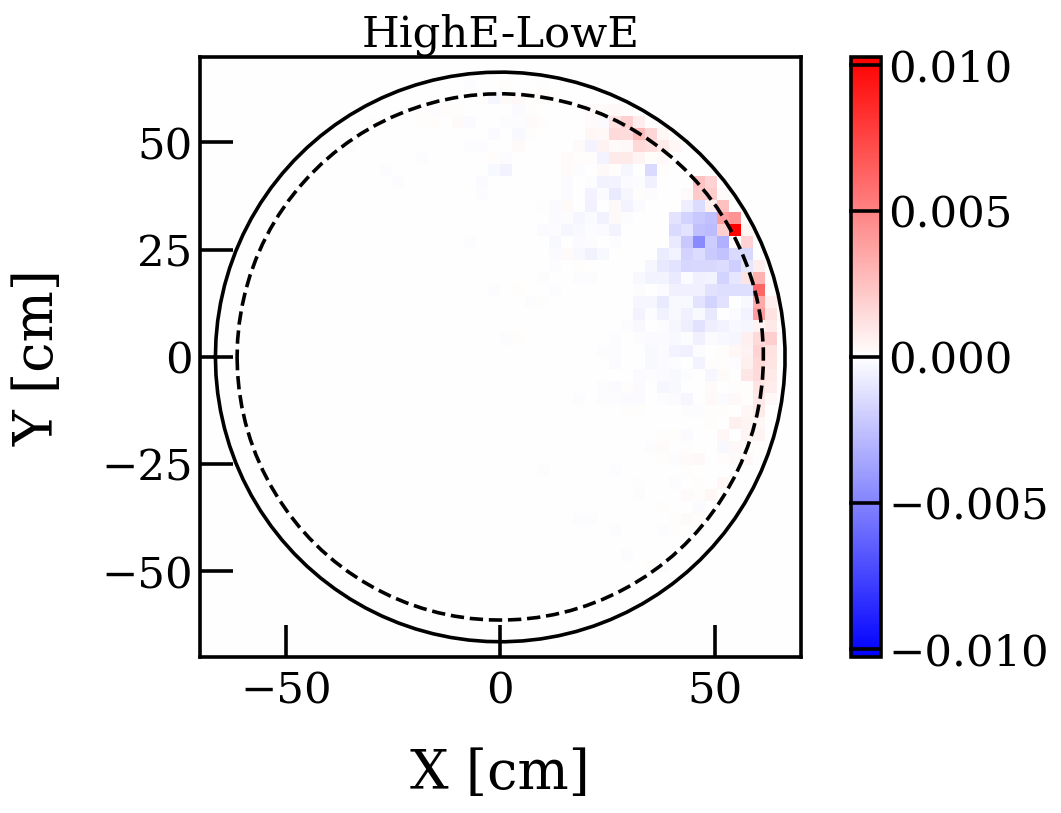

In [104]:
import numpy as np
import matplotlib.pyplot as plt

bins = 50
hist1, xedges, yedges = np.histogram2d(df1['x'], df1['y'], bins=bins, range=[[-70,70], [-70,70]])
hist2, _, _ = np.histogram2d(df2['x'], df2['y'], bins=bins, range=[[-70,70], [-70,70]])

norm_hist1 = hist1 / np.sum(hist1)
norm_hist2 = hist2 / np.sum(hist2)

theta = np.linspace(-np.pi, np.pi, 100)
x = np.cos(theta)*radius
y = np.sin(theta)*radius
plt.plot(x,y, color='black',label='TPC')

x = np.cos(theta)*max_radius
y = np.sin(theta)*max_radius
plt.plot(x,y, color='black',linestyle='--',label='WIMP FV')

diff_hist = norm_hist1 - norm_hist2

extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
cmap = plt.cm.bwr
max_val = np.max(np.abs(diff_hist))
plt.imshow(diff_hist.T, extent=extent, origin='lower', cmap=cmap, vmin=-max_val, vmax=max_val)
plt.colorbar()
plt.title('HighE-LowE')
plt.xlabel('X [cm]')
plt.ylabel('Y [cm]')
plt.show()


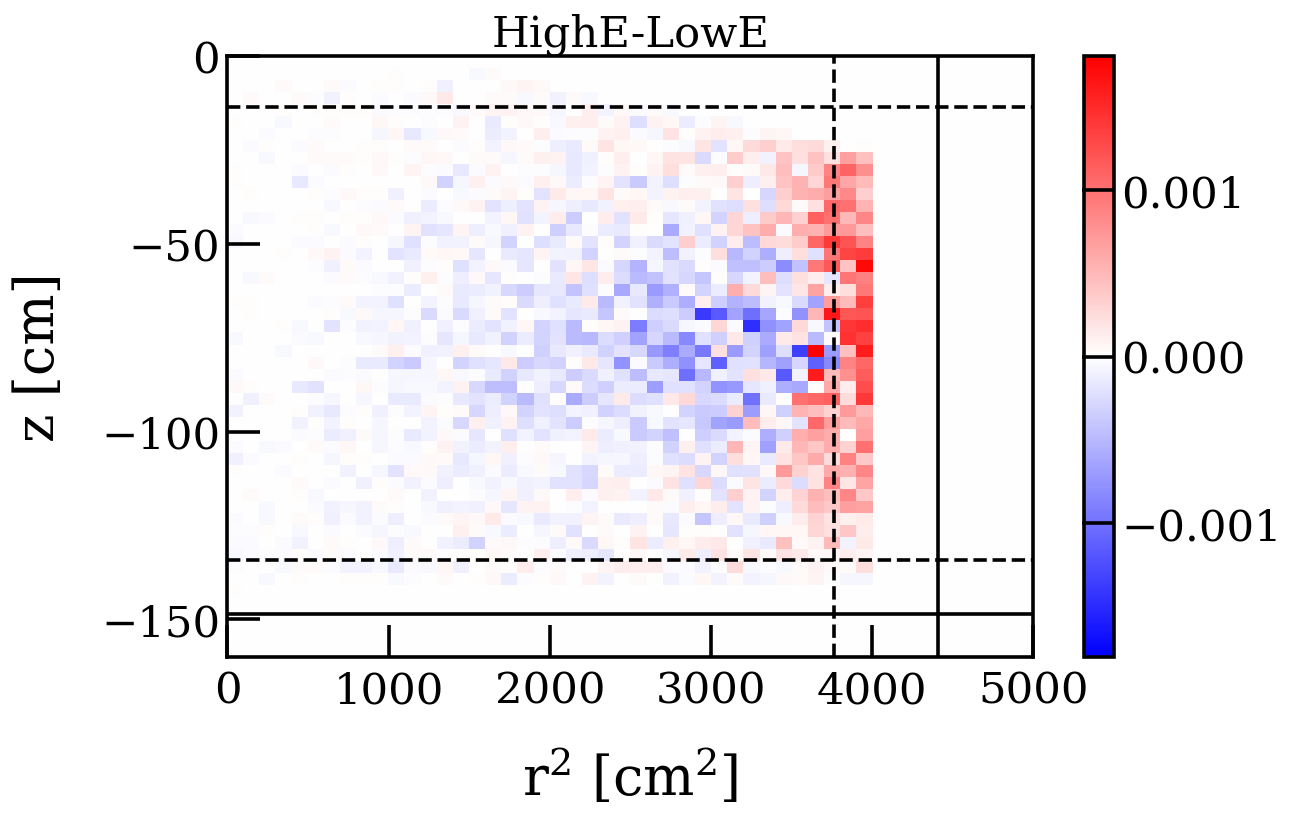

In [106]:
import numpy as np
import matplotlib.pyplot as plt

bins = 50
plt.figure()
xlim=[0,5000]
ylim=[-160,0]
r1 = df1['x']**2 + df1['y']**2
hist1, xedges, yedges = np.histogram2d(r1, df1['z'], bins=bins, range=[xlim,ylim])
r2 = df2['x']**2 + df2['y']**2
hist2, _, _ = np.histogram2d(r2, df2['z'], bins=bins, range=[xlim,ylim])

norm_hist1 = hist1 / np.sum(hist1)
norm_hist2 = hist2 / np.sum(hist2)

diff_hist = norm_hist1 - norm_hist2

plt.hlines([-height], xmin=xlim[0], xmax=xlim[1], color='black')
plt.vlines([max_radius**2], ymin=ylim[0], ymax=ylim[1], color='black',linestyle='--')
plt.vlines([radius**2], ymin=ylim[0], ymax=ylim[1], color='black')
plt.hlines([max_z,min_z], xmin=xlim[0], xmax=xlim[1], color='k', label='FV',linestyle='--')

extent = [0, 5000, -160, 0]
cmap = plt.cm.bwr
max_val = np.max(np.abs(diff_hist))
plt.imshow(diff_hist.T, extent=extent, origin='lower', cmap=cmap, vmin=-max_val, vmax=max_val, aspect='auto')
plt.colorbar()
plt.title('HighE-LowE')
plt.xlabel('r$^2$ [cm$^2$]')
plt.ylabel('z [cm]')
plt.show()


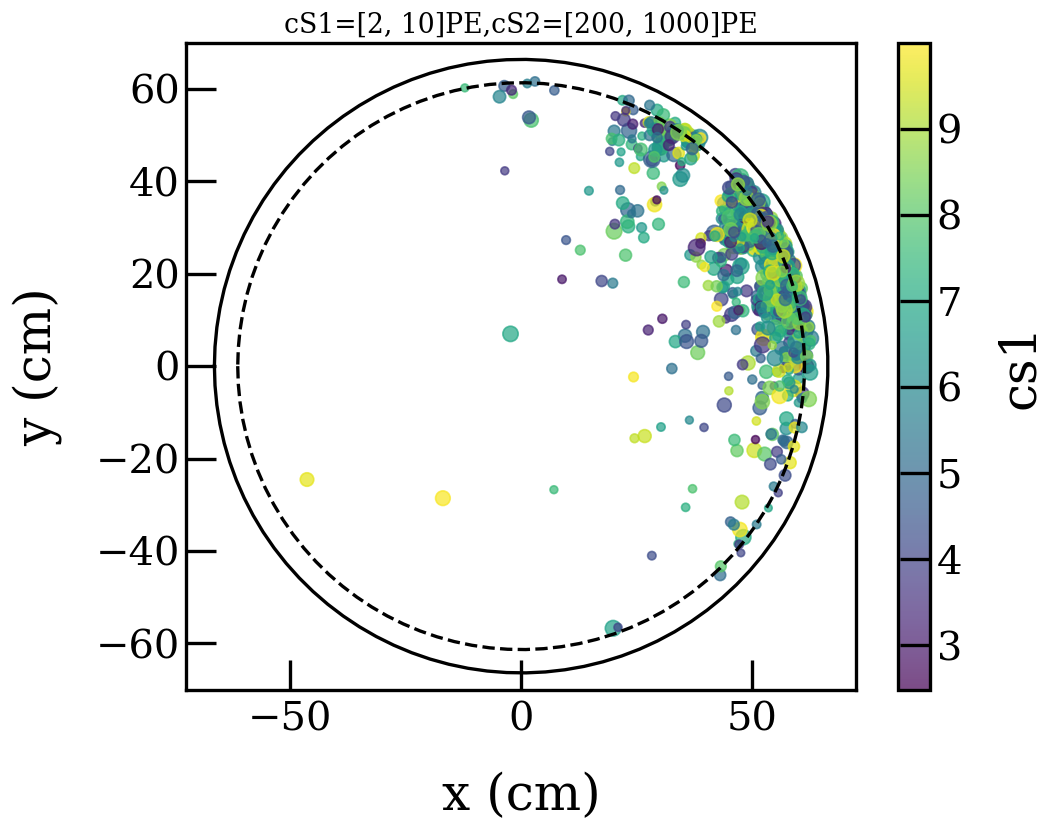

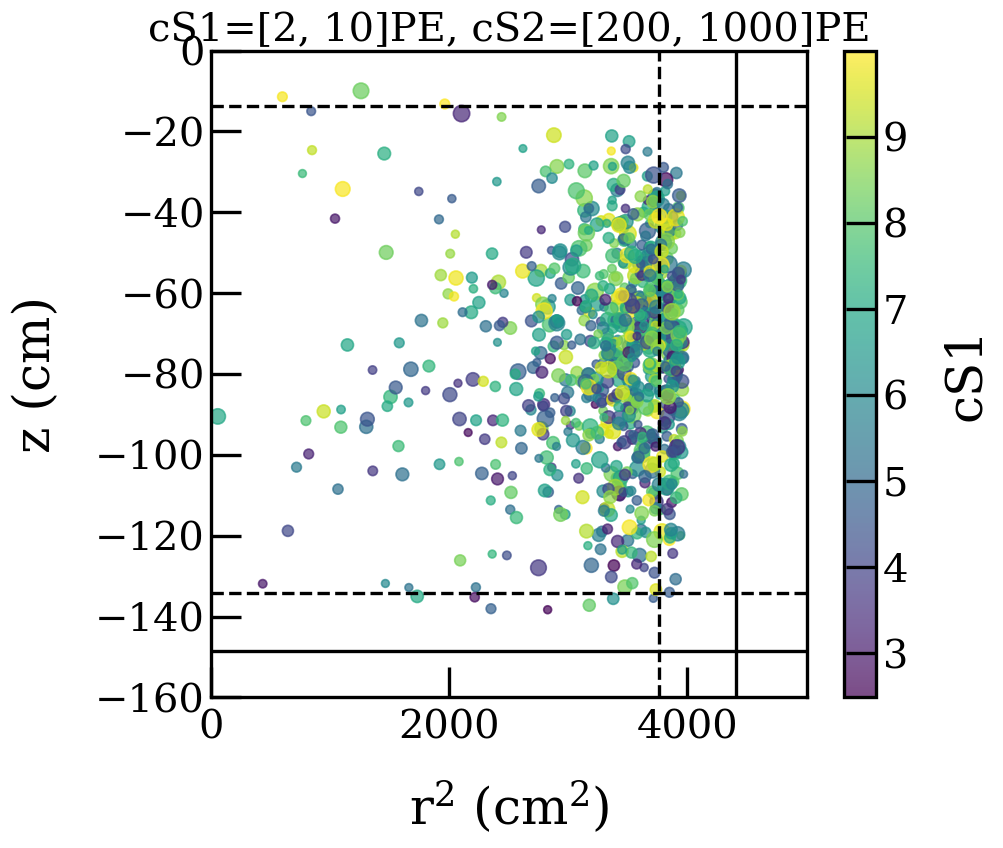

In [69]:
#check xy
cs1_range=[2,10]
cs2_range=[200,1000]
plot_xy(cut_cs1cs2(sim_high[:2000],cs1=cs1_range,cs2=cs2_range),cs1_range,cs2_range)
plot_rz(cut_cs1cs2(sim_high[:2000],cs1=cs1_range,cs2=cs2_range),cs1_range,cs2_range)

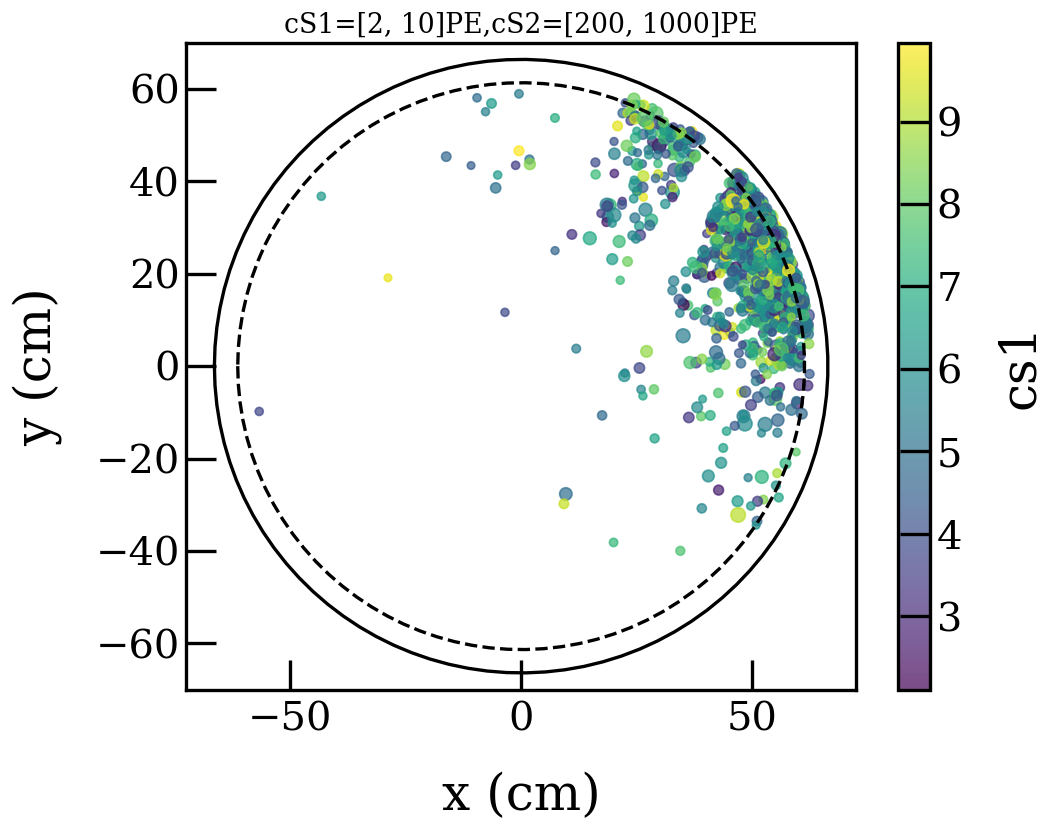

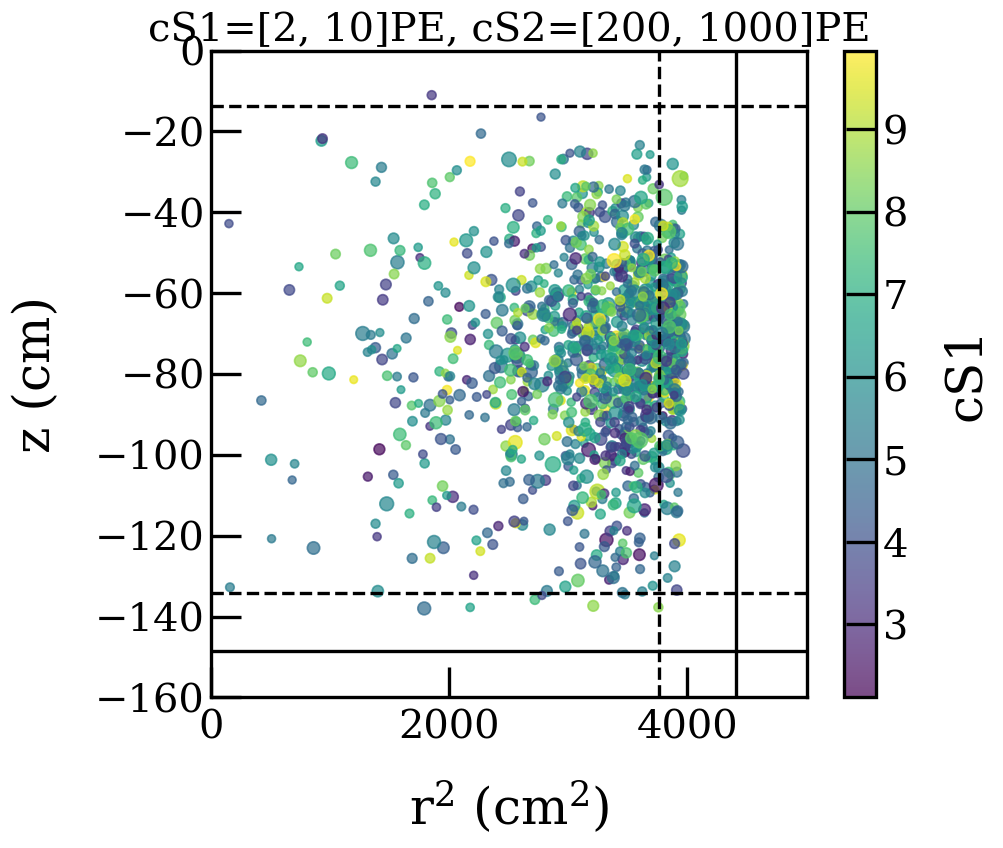

In [68]:
#check xy
cs1_range=[2,10]
cs2_range=[200,1000]
plot_xy(cut_cs1cs2(sim[:2000],cs1=cs1_range,cs2=cs2_range),cs1_range,cs2_range)
plot_rz(cut_cs1cs2(sim[:2000],cs1=cs1_range,cs2=cs2_range),cs1_range,cs2_range)

In [18]:
AC_hour=1/normalization*365*24

In [66]:
len(ac_sample_to_fit)*bkg_sim_s

NameError: name 'bkg_sim_s' is not defined

In [20]:
#branching ratio
#https://arxiv.org/pdf/1602.05911.pdf
br=0.0071

In [40]:
print('expected highE:')
sim_s*len(cut_cs1cs2(sim_high,cs1=[2,10],cs2=[200,1000]))*br

expected highE:


4.788903995741415

In [39]:
print('events number from data:')
len(cut_cs1cs2(data_cuts,cs1=[2,10],cs2=[200,1000]))

events number from data:


204

In [65]:
print('expeted lowE:')
sim_s*len(cut_cs1cs2(sim,cs1=[2,10],cs2=[200,1000]))

expeted lowE:


180.94762829675452

In [67]:
len(cut_cs1cs2(sim_high,cs1=[2,10],cs2=[200,1000]))*br/len(cut_cs1cs2(sim,cs1=[2,10],cs2=[200,1000]))

0.026465690878730956

In [41]:
import GOFevaluation as ge
data_sample=cut_cs1cs2(data_cuts,cs1=[2.5,20],cs2=[200,600])
reference_sample=cut_cs1cs2(sim,cs1=[2.5,20],cs2=[200,600])

data_sample=np.array(data_sample[['cs1','cs2']])
reference_sample=np.array(reference_sample[['cs1','cs2']])
ref_model_0=reference_sample

In [42]:
sim_high_scale=get_random(sim_high,int(len(sim_high)*br))
sim_mixed=pd.concat([sim, sim_high_scale])

In [117]:
   
    
def plot_cs1cs2_new(df_data, df_sim=None, xlim=[0,20], ylim=[0,1500], xlabel='cS1 [PE]', ylabel='cS2 [PE]', data_label='YBe data (44h)',sim_label='YBe sim (91h)',plot_sim=None):

    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.ticker import NullFormatter

    nullfmt = NullFormatter()         # no labels
    
    rate_l, rate_err_l=rate_hz_in_box(df_data,rate_box_cs1,rate_box_cs2,dtype='data')
    rate_s, rate_err_s=rate_hz_in_box(df_data,rate_box_cs1_sm,rate_box_cs2_sm,dtype='data')

    
    sim_rate_l, sim_rate_l_err=rate_hz_in_box(df_sim,rate_box_cs1,rate_box_cs2,dtype='sim')
    sim_rate_s, sim_rate_s_err=rate_hz_in_box(df_sim,rate_box_cs1_sm,rate_box_cs2_sm,dtype='sim')

    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    bottom_h = left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.2]
    rect_histy = [left_h, bottom, 0.2, height]

    # start with a rectangular Figure
    plt.figure(1, figsize=(12, 12))

    axScatter = plt.axes(rect_scatter)
    axHistx = plt.axes(rect_histx)
    axHisty = plt.axes(rect_histy)

    # no labels
    axHistx.xaxis.set_major_formatter(nullfmt)
    axHisty.yaxis.set_major_formatter(nullfmt)

    # now determine nice limits by hand:
    data_cuts=cut_cs1cs2(df_data,xlim,ylim)
    x=data_cuts['cs1']
    y=data_cuts['cs2']


    axScatter.set_xlim(xlim)
    axScatter.set_ylim(ylim)
    
    cut_sim=cut_cs1cs2(df_sim,xlim,ylim)
    x_sim=cut_sim['cs1']
    y_sim=cut_sim['cs2']
        

    xbins = np.linspace(xlim[0],xlim[1],50)
    ybins = np.linspace(ylim[0],ylim[1],50)
    axHistx.hist(x, bins=xbins,histtype='step',linewidth=2,color='k',label=data_label)
    axHisty.hist(y, bins=ybins, orientation='horizontal',histtype='step',linewidth=2,color='k',label=data_label)
    axHistx.hist(x_sim, bins=xbins,histtype='step',linewidth=2,color='b',label=sim_label)
    axHisty.hist(y_sim, bins=ybins, orientation='horizontal',histtype='step',linewidth=2,color='b',label=sim_label)
    axHistx.set_ylabel('counts', fontsize = 24)
    axHisty.set_xlabel('counts', fontsize = 24)
    axHistx.legend(fontsize=16)
    # axHisty.legend(fontsize=16)

    axHistx.set_xlim(axScatter.get_xlim())
    axHisty.set_ylim(axScatter.get_ylim())
    axHistx.set_yscale('log')
    axHisty.set_xscale('log')



    axScatter.scatter(x,y,color='k', marker='o',label=data_label, s=10,alpha=0.8)                  
    axScatter.set_xlabel(xlabel, fontsize = 24)
    axScatter.set_ylabel(ylabel, fontsize = 24)
    


    axScatter.plot(xx1, yy1, color='purple',linestyle='--')
    axScatter.plot(xx,yy, color='purple',linestyle='--',label='$^{220}$Rn median 90%',linewidth=3)
    
    if(plot_sim=='scatter'):
        axScatter.scatter(x_sim,y_sim,color='b',marker='o',label=sim_label,s=10,alpha=0.6)
    elif(plot_sim=='contour'):
        xxx, yyy = np.mgrid[xlim[0]:xlim[1]:100j, ylim[0]:ylim[1]:100j]
        positions = np.vstack([xxx.ravel(), yyy.ravel()])
        values = np.vstack([x_sim, y_sim])
        kernel = stats.gaussian_kde(values)
        f = np.reshape(kernel(positions).T, xxx.shape)
        contours_sim = axScatter.contour(xxx, yyy, f, levels=3, colors='b', linewidths=2, label=sim_label+' contour')
        axScatter.clabel(contours_sim, inline=True, fontsize=8)

    
    axScatter.legend(fontsize=16)

    plt.show()
    return axScatter, axHistx, axHisty

/home/scli/YBe/YBe_tool.py:569: UserWarning: The following kwargs were not used by contour: 'label'
  contours_sim = axScatter.contour(xxx, yyy, f, levels=3, colors='b', linewidths=2, label=sim_label+' contour')


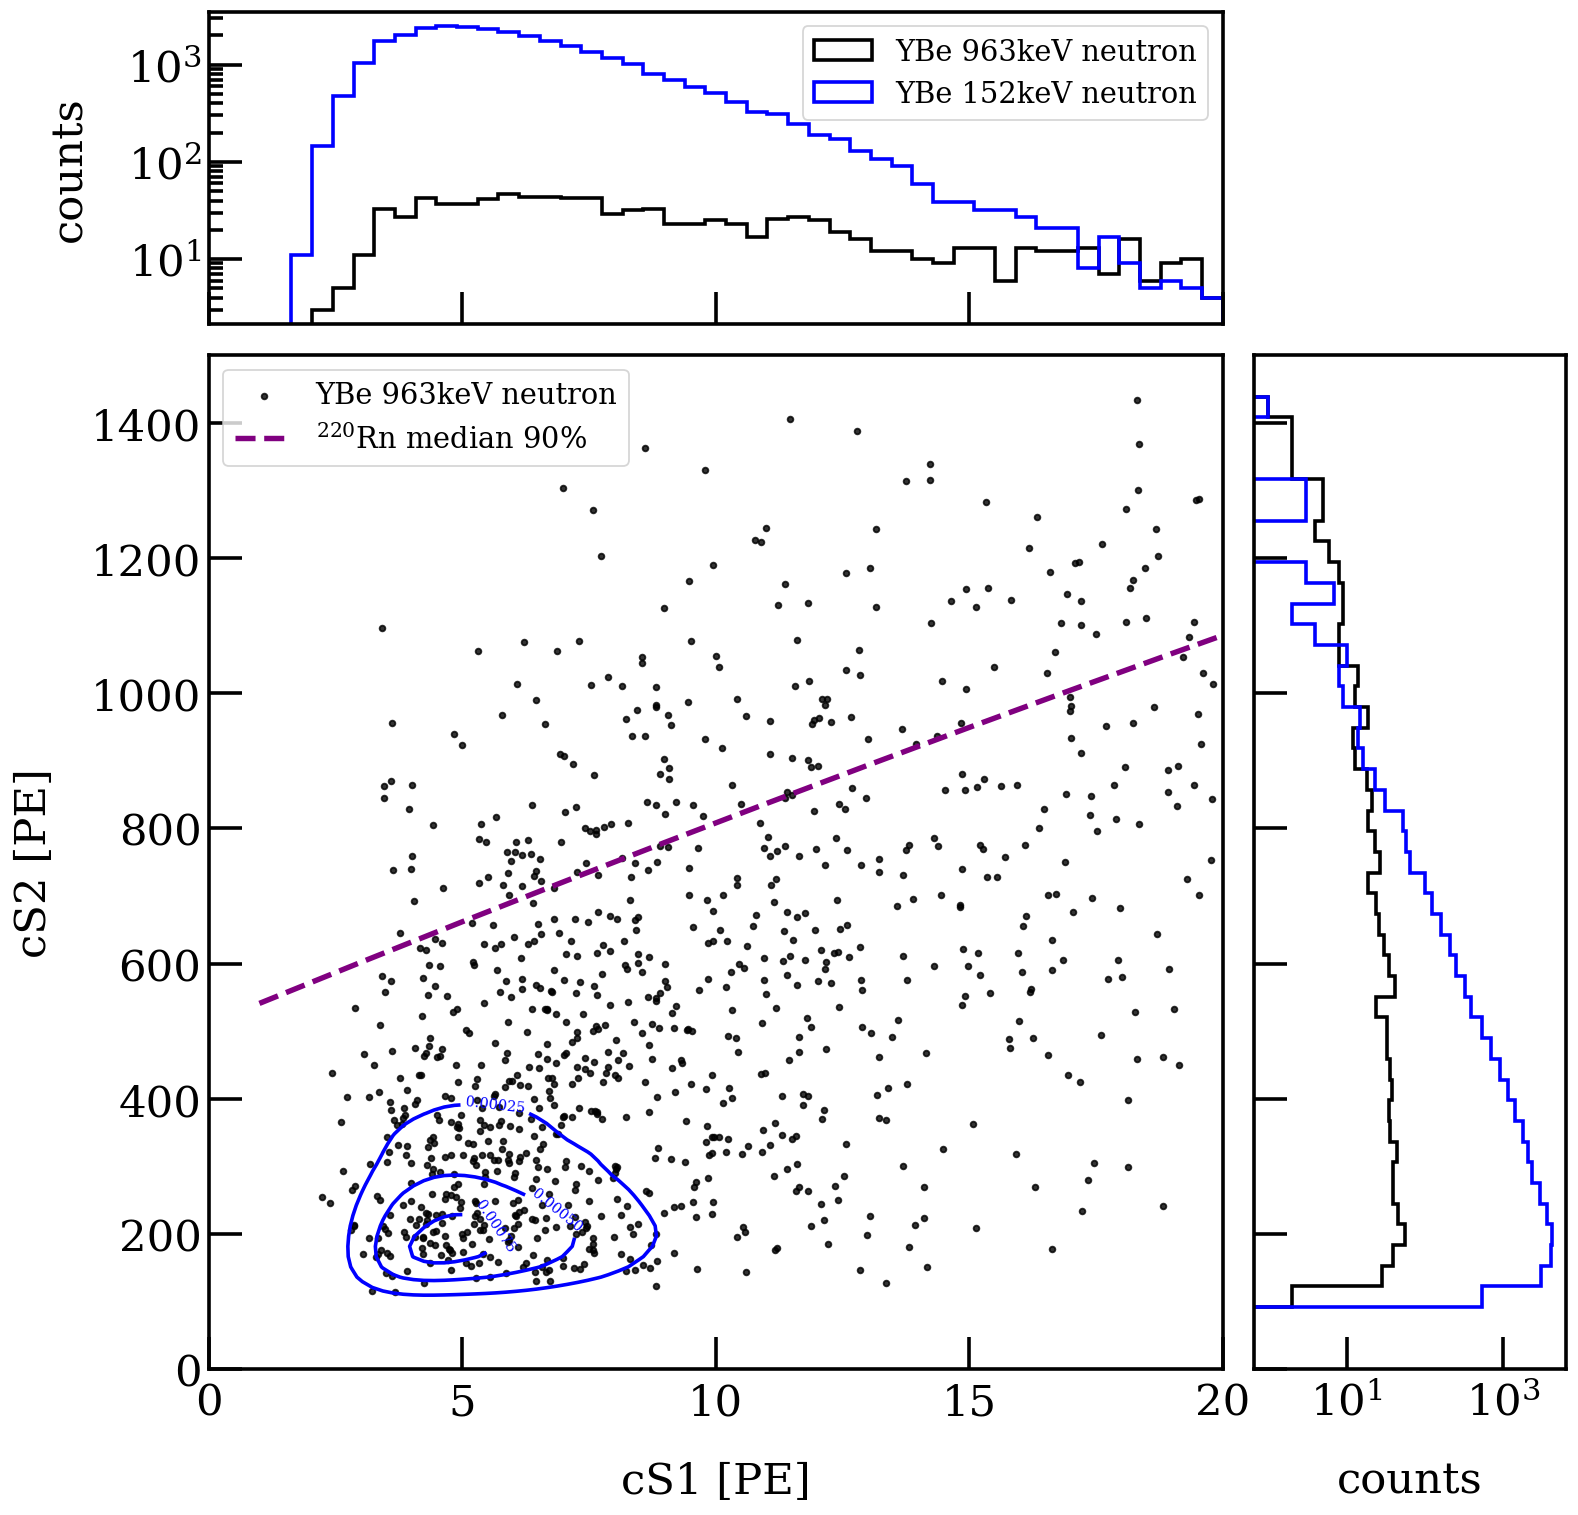

(<Axes:xlabel='cS1 [PE]', ylabel='cS2 [PE]'>,
 <Axes:ylabel='counts'>,
 <Axes:xlabel='counts'>)

In [43]:
plot_cs1cs2_new(sim_high_scale,df_sim=sim,\
                data_label=f'YBe 963keV neutron',plot_sim='contour',\
                sim_label=f'YBe 152keV neutron')

/home/scli/YBe/YBe_tool.py:569: UserWarning: The following kwargs were not used by contour: 'label'
  contours_sim = axScatter.contour(xxx, yyy, f, levels=3, colors='b', linewidths=2, label=sim_label+' contour')


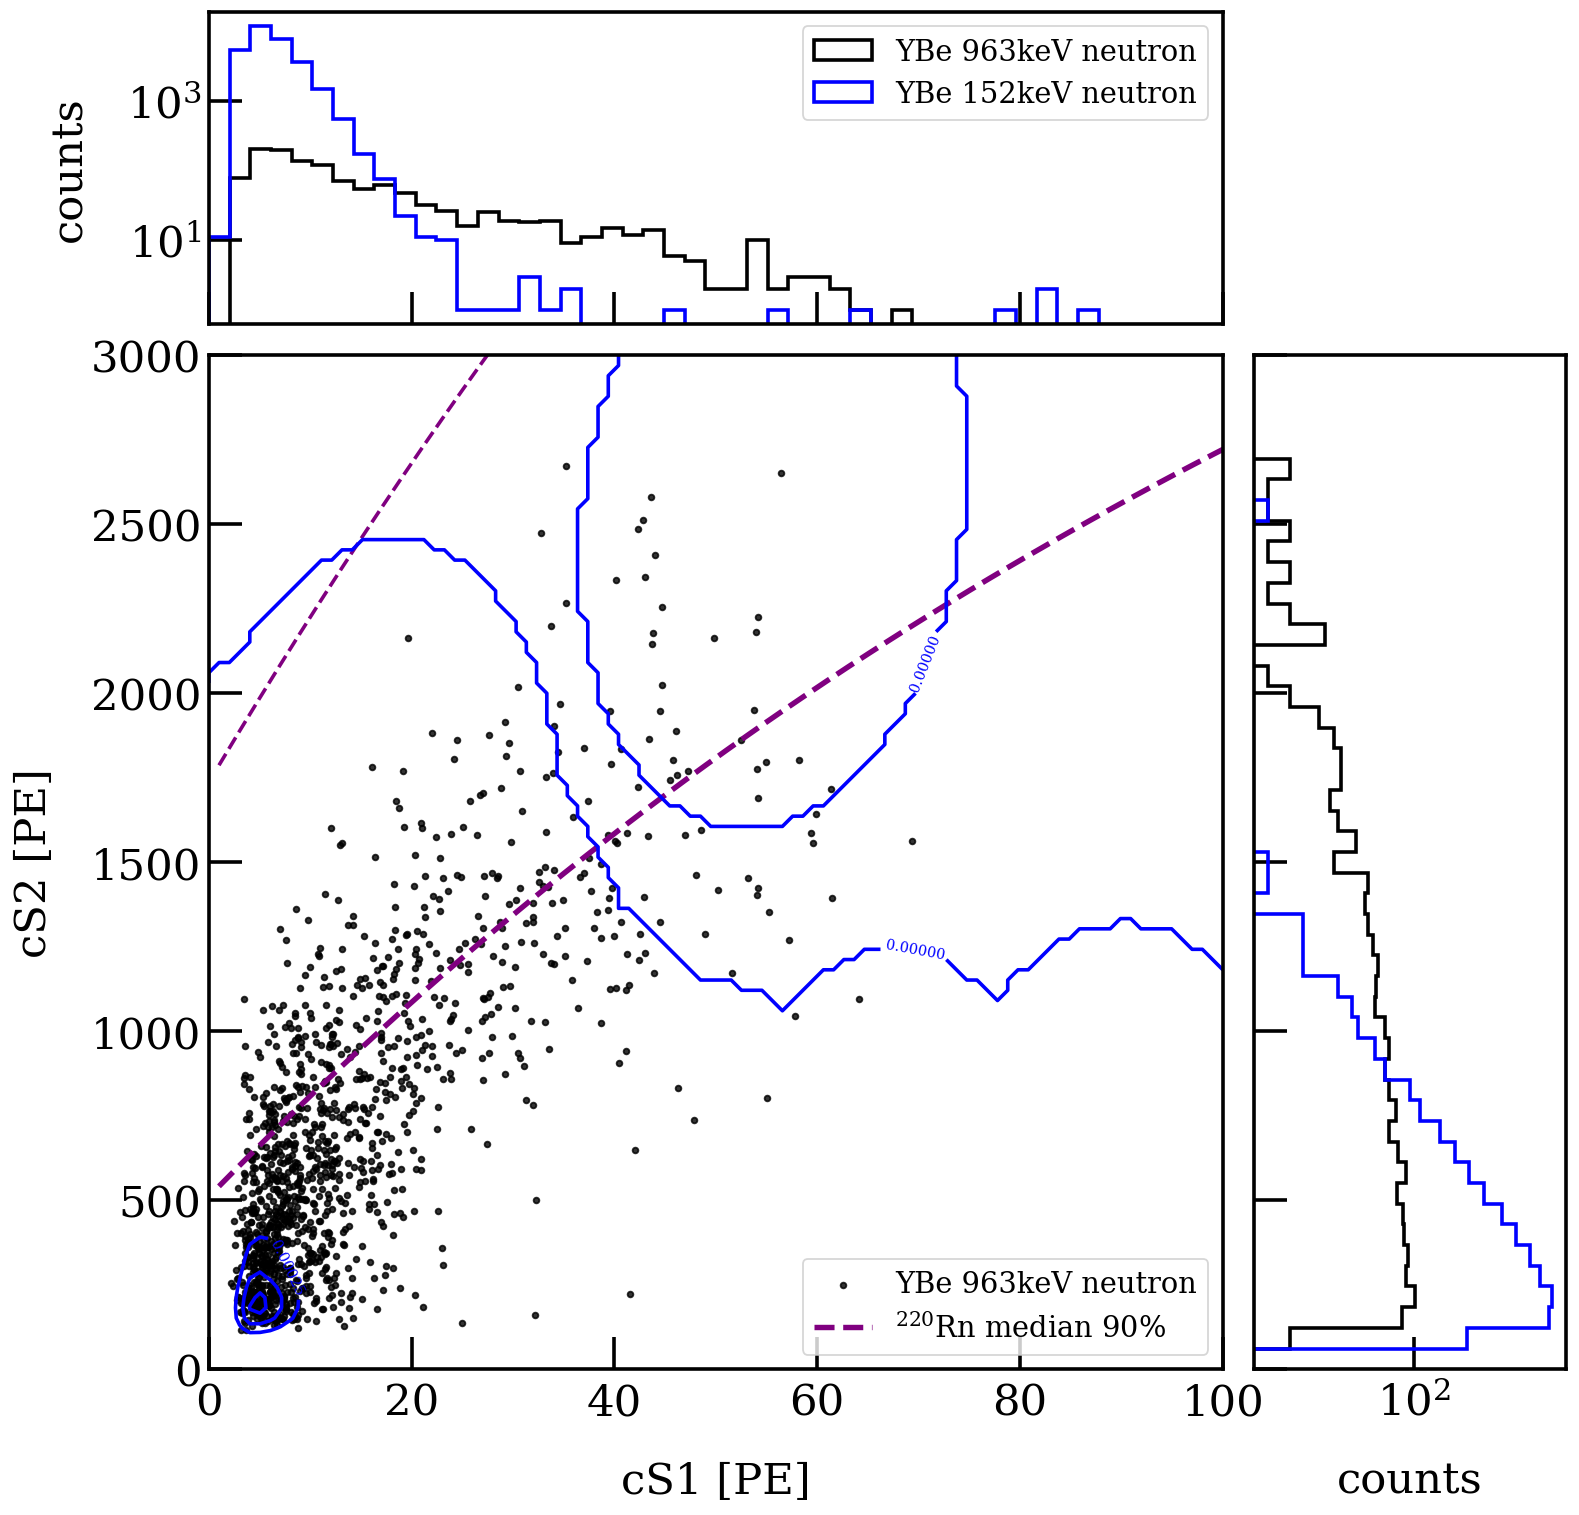

(<Axes:xlabel='cS1 [PE]', ylabel='cS2 [PE]'>,
 <Axes:ylabel='counts'>,
 <Axes:xlabel='counts'>)

In [44]:
plot_cs1cs2_new(sim_high_scale,df_sim=sim,\
                data_label=f'YBe 963keV neutron',plot_sim='contour',\
                sim_label=f'YBe 152keV neutron',\
               xlim=[0,100],ylim=[0,3000])

In [45]:

def GOF_equal_prob(data,sim,cs1_range,cs2_range,label='',sim_scale=None):

    data_sample=cut_cs1cs2(data,cs1=cs1_range,cs2=cs2_range)
    reference_sample=cut_cs1cs2(sim,cs1=cs1_range,cs2=cs2_range)

    data_sample=np.array(data_sample[['cs1','cs2']])
    reference_sample=np.array(reference_sample[['cs1','cs2']])
    ref_model_0=reference_sample

    fig, axes = plt.subplots(1, 1, figsize=(10, 10))
    if(sim_scale==None):
        n_expectations=len(data_sample)
    else:
        n_expectations=len(reference_sample)*sim_scale
    print(len(data_sample),len(reference_sample)*sim_s )
    # define eqpb parameters
    order = [0, 1]  # [0, 1] means that first dimension 0 is binned, then dimension 1
    n_partitions = [6, 6]  # 5 partitions in dim. 0 and 6 partitions in dim. 1

    # perform GOF tests
    for i, reference_sample in enumerate([reference_sample]):
        gof_object = ge.BinnedPoissonChi2GOF.bin_equiprobable(data_sample=data_sample,
                                                              reference_sample=reference_sample,
                                                              nevents_expected=n_expectations,
                                                              n_partitions=n_partitions,
                                                              order=order,
                                                              plot=True,
                                                              ax=axes
                                                             )

        gof_object.get_pvalue()
        print(f'GOF = {gof_object.gof:.2f}')
        print(f'p-value = {gof_object.pvalue:.4f}\n')

    axes.set_title(label+f'cS1={cs1_range},cS2={cs2_range}'+'\n'+f'GOF = {gof_object.gof:.2f}, '+f'p-value = {gof_object.pvalue:.2f}\n')

    axes.set_xlabel('cS1')
    axes.set_ylabel('cS2')
    plt.tight_layout()
    plt.show()

### Choose such range to ignore AC

In [46]:
cs1_range=[2,10]
cs2_range=[250,1000]

131 127.43003503929238
GOF = 42.76
p-value = 0.3070



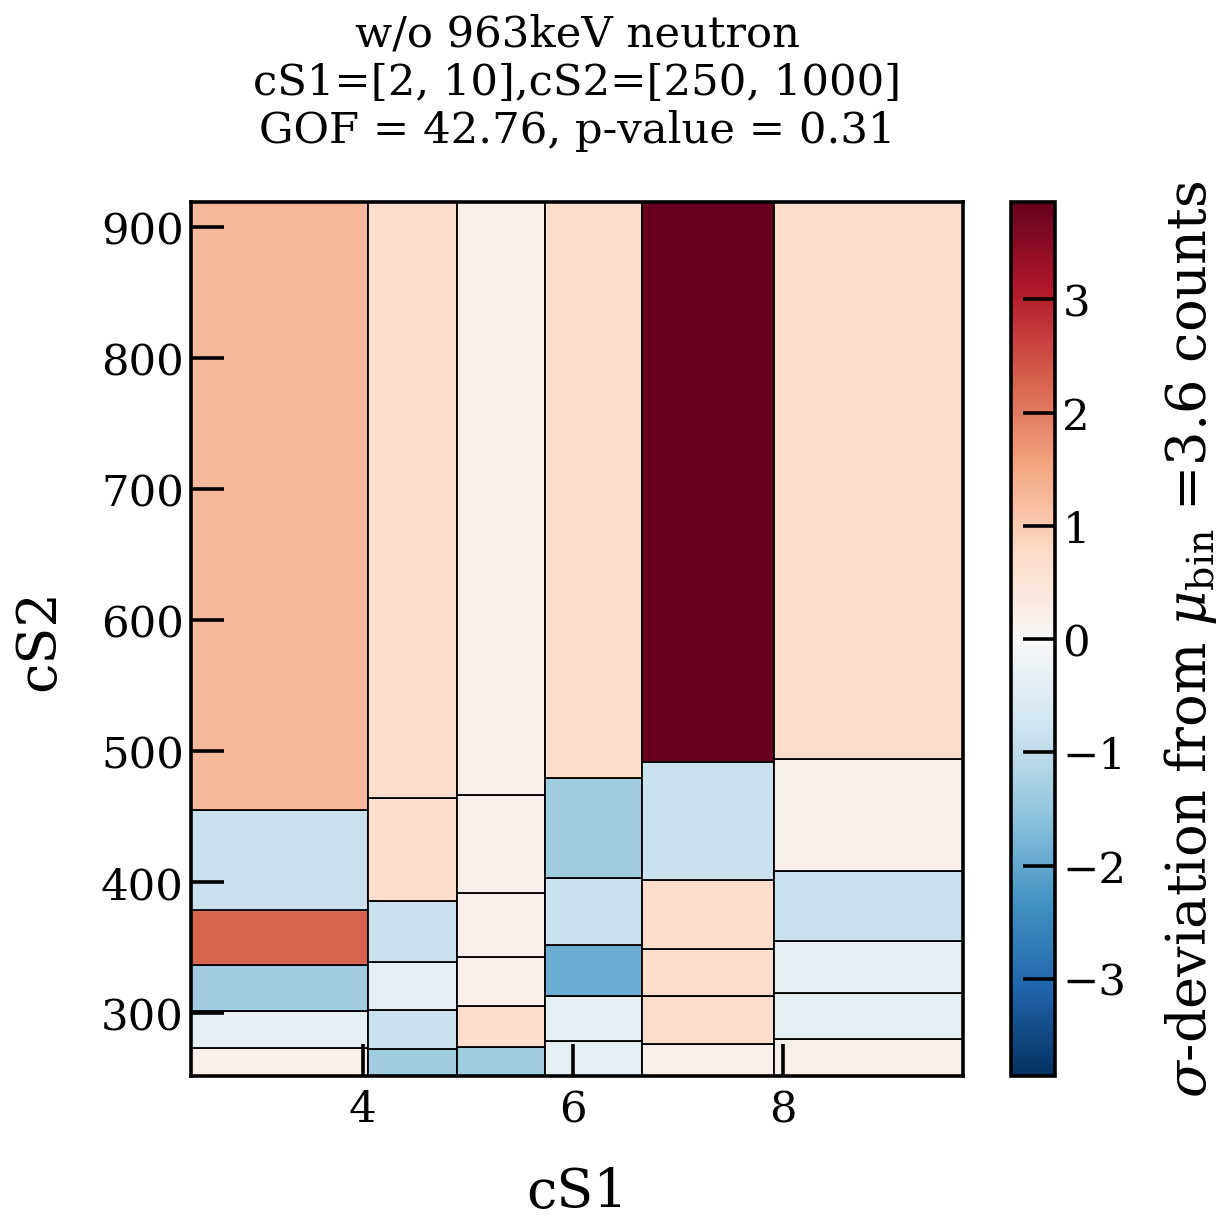

In [47]:

d_in=cut_cs1cs2(wire_cut(data_cuts),cs1=cs1_range,cs2=cs2_range)
s_in=cut_cs1cs2(wire_cut(sim),cs1=cs1_range,cs2=cs2_range)
GOF_equal_prob(d_in,s_in,cs1_range,cs2_range,label='w/o 963keV neutron\n')

131 131.518446803668
GOF = 40.37
p-value = 0.4350



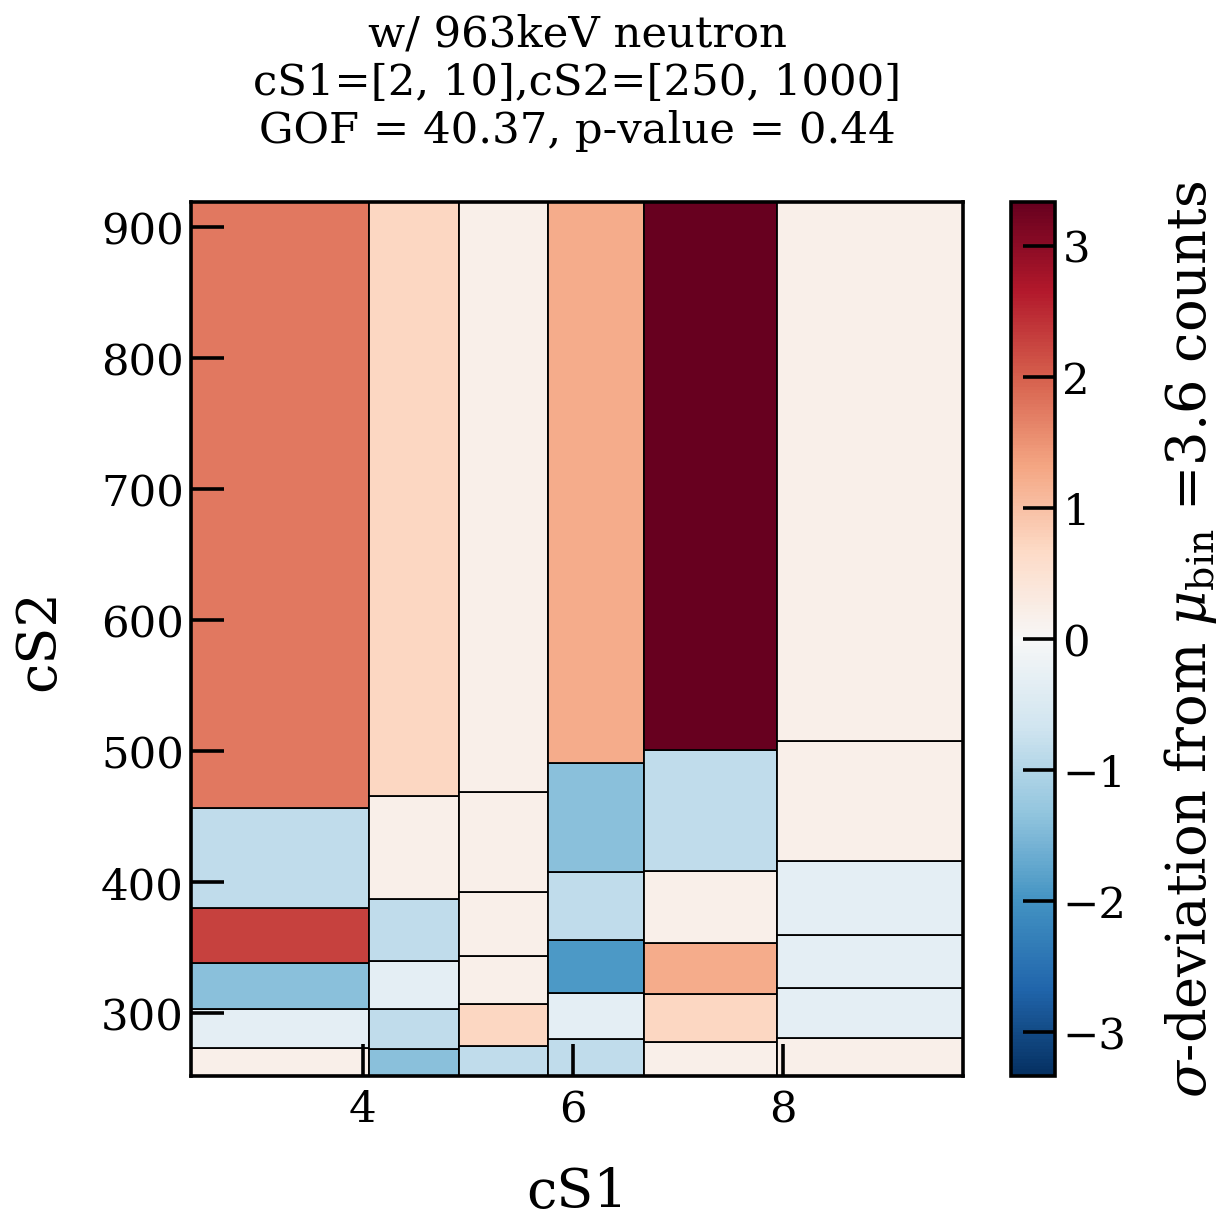

In [48]:

d_in=cut_cs1cs2(wire_cut(data_cuts),cs1=cs1_range,cs2=cs2_range)
s_in=cut_cs1cs2(wire_cut(sim_mixed),cs1=cs1_range,cs2=cs2_range)
GOF_equal_prob(d_in,s_in,cs1_range,cs2_range,label='w/ 963keV neutron\n')

131 127.43003503929238
GOF = 42.86
p-value = 0.3010



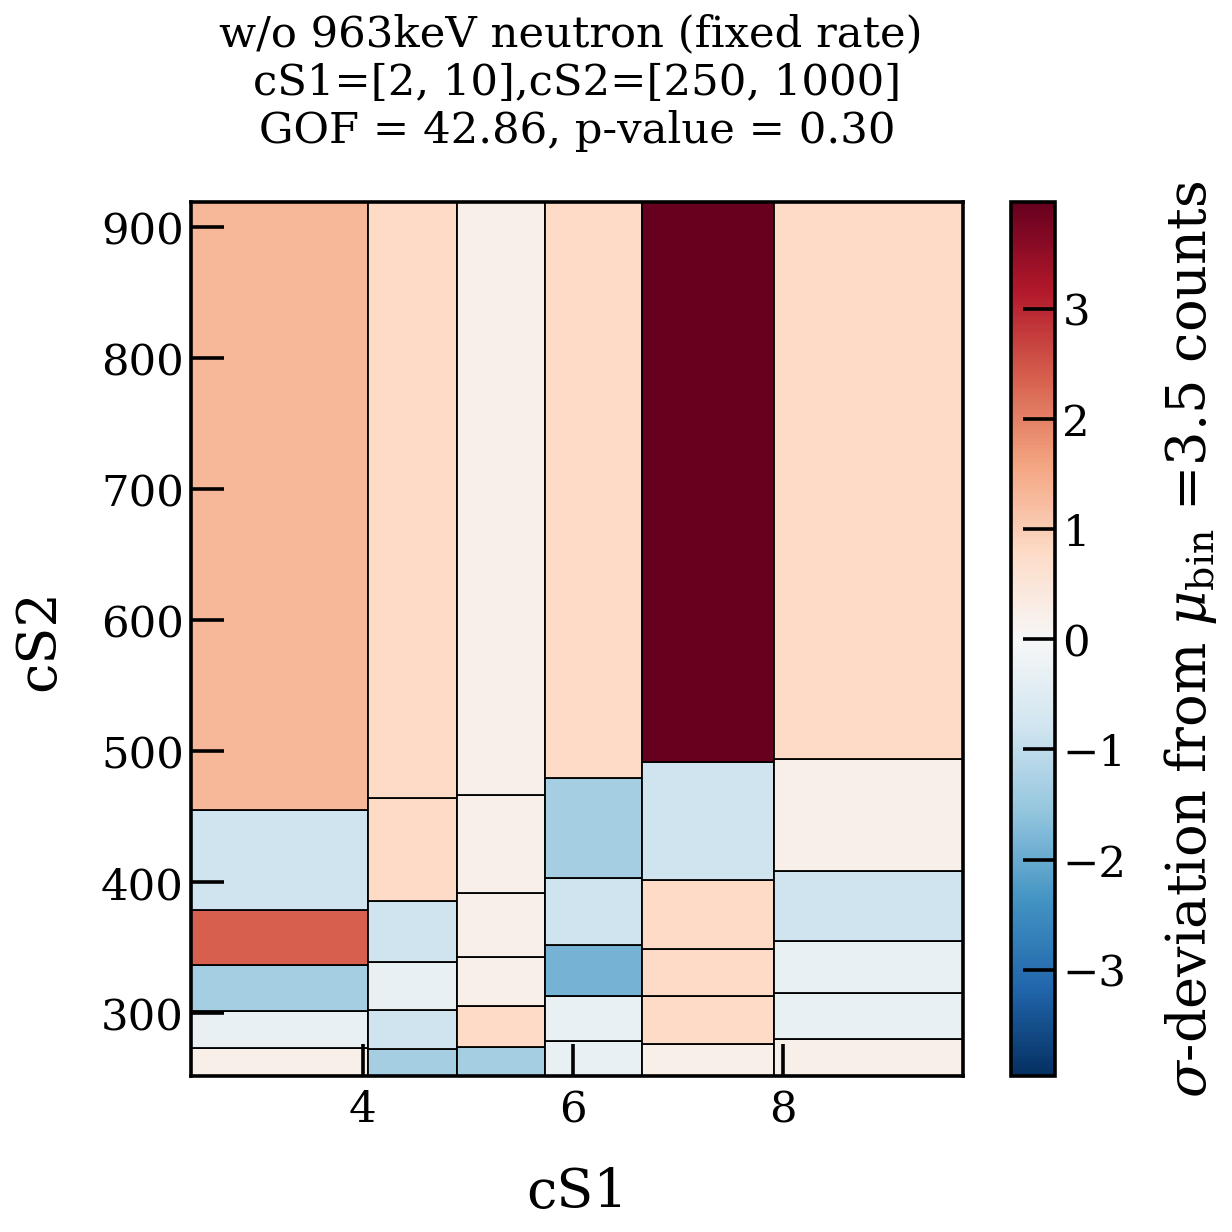

In [49]:
d_in=cut_cs1cs2(wire_cut(data_cuts),cs1=cs1_range,cs2=cs2_range)
s_in=cut_cs1cs2(wire_cut(sim),cs1=cs1_range,cs2=cs2_range)
GOF_equal_prob(d_in,s_in,cs1_range,cs2_range,label='w/o 963keV neutron (fixed rate) \n',sim_scale=sim_s)

131 131.518446803668
GOF = 40.38
p-value = 0.3910



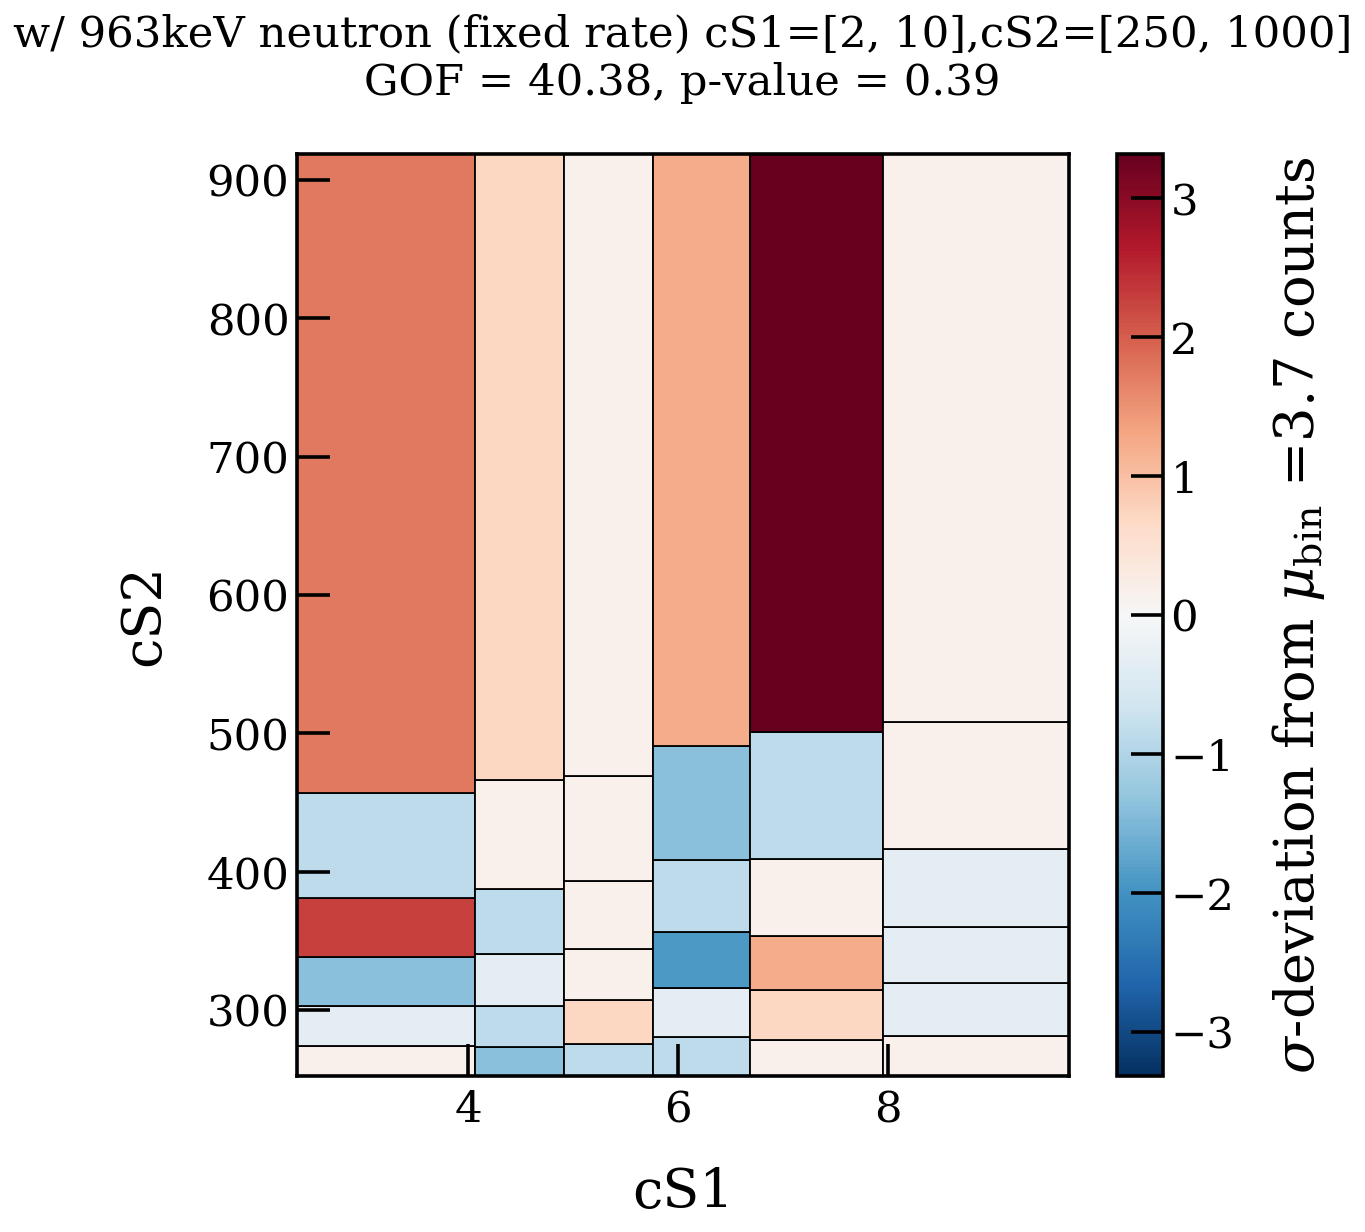

In [50]:
d_in=cut_cs1cs2(wire_cut(data_cuts),cs1=cs1_range,cs2=cs2_range)
s_in=cut_cs1cs2(wire_cut(sim_mixed),cs1=cs1_range,cs2=cs2_range)
GOF_equal_prob(d_in,s_in,cs1_range,cs2_range,label='w/ 963keV neutron (fixed rate) ',sim_scale=sim_s)

In [51]:

def GOF_simp(data,sim,cs1_range,cs2_range,label='',sim_scale=None,if_plot=True):

    data_sample=cut_cs1cs2(data,cs1=cs1_range,cs2=cs2_range)
    reference_sample=cut_cs1cs2(sim,cs1=cs1_range,cs2=cs2_range)

    data_sample=np.array(data_sample[['cs1','cs2']])
    reference_sample=np.array(reference_sample[['cs1','cs2']])
    ref_model_0=reference_sample

    # fig, axes = plt.subplots(1, 1, figsize=(10, 10))
    axes=None
    if(sim_scale==None):
        n_expectations=len(data_sample)
    else:
        n_expectations=len(reference_sample)*sim_scale
    order = [0, 1]  # [0, 1] means that first dimension 0 is binned, then dimension 1
    n_partitions = [6, 6]  # 5 partitions in dim. 0 and 6 partitions in dim. 1

    # perform GOF tests
    
    gof_object = ge.BinnedPoissonChi2GOF.bin_equiprobable(data_sample=data_sample,
                                                          reference_sample=reference_sample,
                                                          nevents_expected=n_expectations,
                                                          n_partitions=n_partitions,
                                                          order=order,
                                                          plot=False,
                                                          ax=axes
                                                         )

    gof_object.get_pvalue()
    return gof_object.gof, gof_object.pvalue

In [52]:
gof=[]
pv=[]
d_in=cut_cs1cs2(wire_cut(data_cuts),cs1=cs1_range,cs2=cs2_range)
for i in tqdm.tqdm(range(200)):
    sim_high_scale=get_random(sim_high,int(len(sim_high)*br))
    sim_mixed=pd.concat([sim, sim_high_scale])
    s_in=cut_cs1cs2(wire_cut(sim_mixed),cs1=cs1_range,cs2=cs2_range)
    res=GOF_simp(d_in,s_in,cs1_range,cs2_range,sim_scale=sim_s)
    gof.append(res[0])
    pv.append(res[1])
    

100%|██████████| 200/200 [07:28<00:00,  2.24s/it]


In [53]:
gof_0,pv_0=GOF_simp(cut_cs1cs2(wire_cut(data_cuts),\
                               cs1=cs1_range,cs2=cs2_range),\
                    cut_cs1cs2(wire_cut(sim),cs1=cs1_range,cs2=cs2_range),\
                    cs1_range,cs2_range,sim_scale=sim_s)

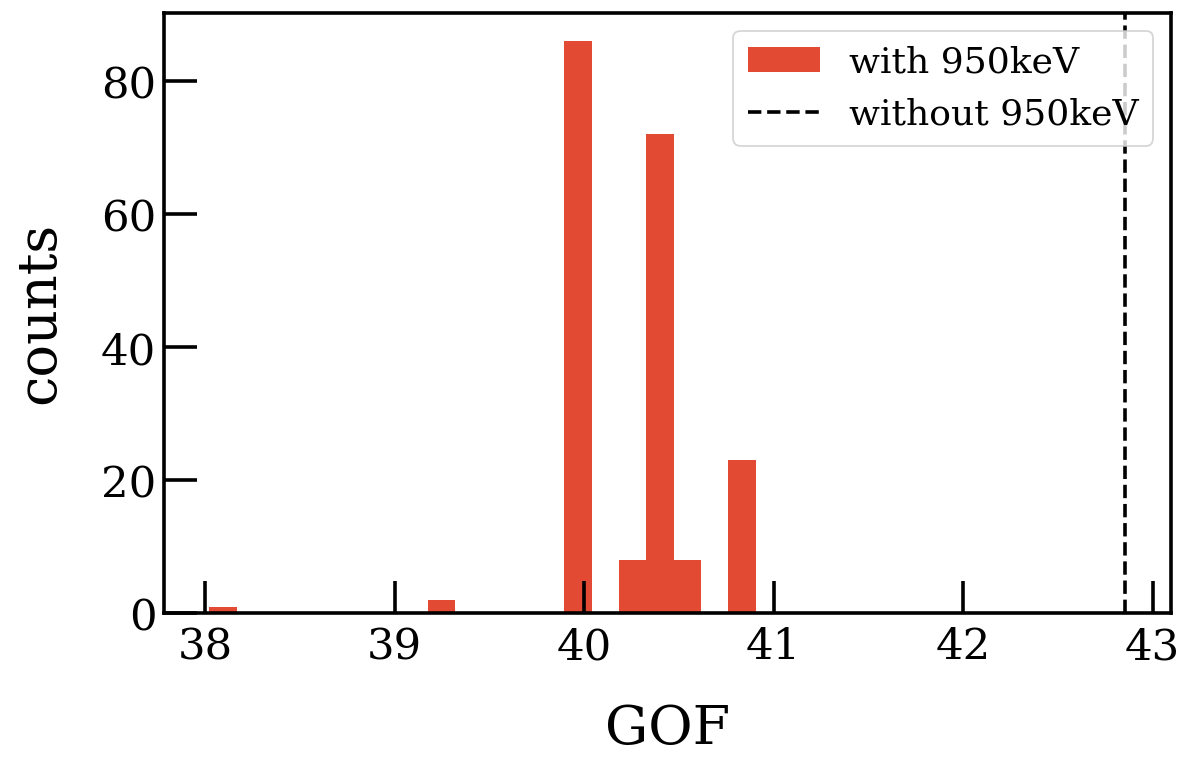

In [62]:
plt.hist(gof,bins=20,label='with 950keV')
plt.axvline(gof_0,color='k',linestyle='--',label='without 950keV')
plt.ylabel('counts')
plt.xlabel('GOF')
plt.legend(fontsize=20)

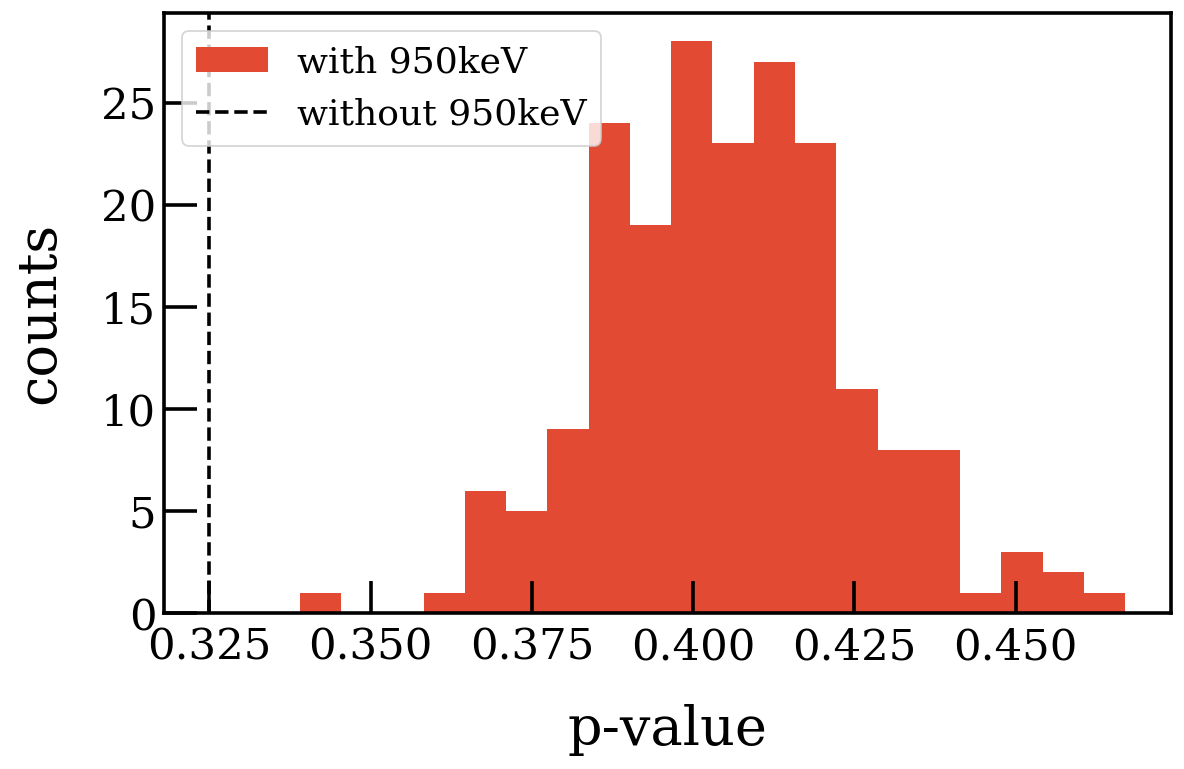

In [61]:
plt.hist(pv,bins=20,label='with 950keV')
plt.axvline(pv_0,color='k',linestyle='--',label='without 950keV')
plt.ylabel('counts')
plt.xlabel('p-value')
plt.legend(fontsize=20)